In [ ]:
from PIL import Image
import torch
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES

from inference_utils.inference import interactive_infer_image
from inference_utils.output_processing import check_mask_stats
# P-value (adjusted) that the segmentation belongs to "nodule" in the CT-Chest class
# Lower p-value indicates it is likely the segmentation not belongs to the class. Recommended threshold is 0.05

In [ ]:
import huggingface_hub

HF_TOKEN = 'YOUR_HUGGINGFACE_TOKEN'

huggingface_hub.login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/theodorezhao/.cache/huggingface/token
Login successful


### Model Setup

In [79]:
# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
pretrained_pth = 'hf_hub:microsoft/BiomedParse'

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([17])


### Utility Functions

In [80]:
def plot_segmentation_masks(original_image, segmentation_masks, texts, rotate=0):
    ''' Plot a list of segmentation mask over an image.
    '''
    original_image = original_image[:, :, :3]
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(np.rot90(original_image, rotate), cmap='gray')
    ax[0].set_title('Original Image')
    # grid off
    for a in ax:
        a.axis('off')

    for i, mask in enumerate(segmentation_masks):
        
        ax[i+1].set_title(texts[i])
        mask_temp = original_image.copy()
        mask_temp[mask > 0.5] = [255, 0, 0]
        mask_temp[mask <= 0.5] = [0, 0, 0, ]
        ax[i+1].imshow(np.rot90(mask_temp, rotate), alpha=0.9)
        ax[i+1].imshow(np.rot90(original_image, rotate), cmap='gray', alpha=0.5)
        
    
    plt.show()

In [81]:
!pip install pydicom nibabel SimpleITK

import json
import matplotlib.pyplot as plt

from inference_utils.processing_utils import read_nifti


def inference_nifti(file_path, text_prompts, is_CT, slice_idx, site=None, HW_index=(0, 1), channel_idx=None, rotate=0):
    image = read_nifti(file_path, is_CT, slice_idx, site=site, 
                       HW_index=HW_index, channel_idx=channel_idx)
    
    pred_mask = interactive_infer_image(model, Image.fromarray(image), text_prompts)

    # Plot feature over image
    plot_segmentation_masks(image, pred_mask, text_prompts, rotate=rotate)
    
    return image, pred_mask


### Ultrasound Example

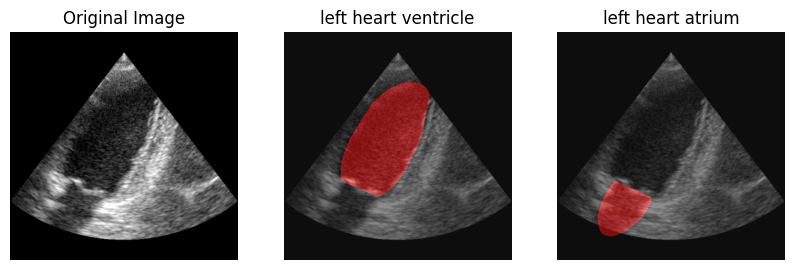

left heart ventricle P-value: 0.3866670318633151
left heart atrium P-value: 0.43733995722336566


In [82]:
image_path = 'examples/patient0500_2CH_half_sequence.nii.gz'
text_prompt = ['left heart ventricle', 'left heart atrium']
slide_idx = 0

image, pred_mask = inference_nifti(image_path, text_prompt, is_CT=False, slice_idx=slide_idx, site=None, rotate=3)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Ultrasound-Cardiac', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### MRI Example
#### T1-Gd

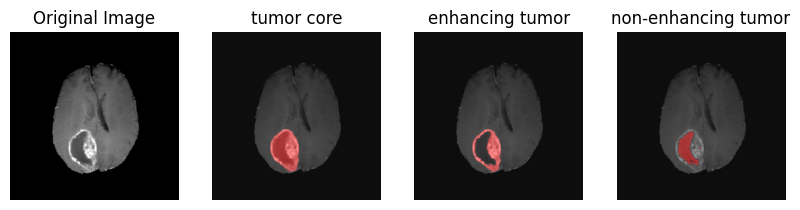

tumor core P-value: 0.31703698646250394
enhancing tumor P-value: 0.5496207060714963
non-enhancing tumor P-value: 0.07897145649539007


In [83]:
image_path = 'examples/BRATS_397.nii.gz'
text_prompt = ['tumor core', 'enhancing tumor', 'non-enhancing tumor']
slide_idx = 89

image, pred_mask =  inference_nifti(image_path, text_prompt, is_CT=False, slice_idx=slide_idx, site=None, channel_idx=2, rotate=1)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'MRI-T1-Gd-Brain', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

#### FLAIR

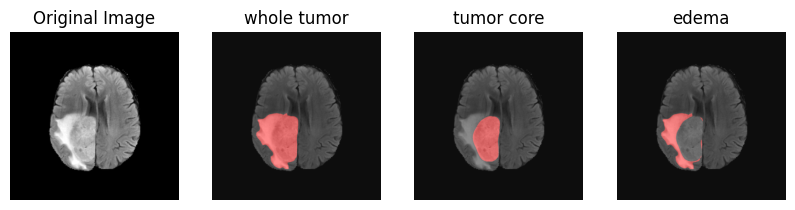

whole tumor P-value: 0.2934591381007444
tumor core P-value: 0.4401112952701697
edema P-value: 0.316755534409188


In [84]:
image_path = 'examples/BRATS_422.nii.gz'
text_prompt = ['whole tumor', 'tumor core', 'edema']
slide_idx = 84

image, pred_mask =  inference_nifti(image_path, text_prompt, is_CT=False, slice_idx=slide_idx, site=None, channel_idx=0, rotate=1)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'MRI-FLAIR-Brain', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### CT Example

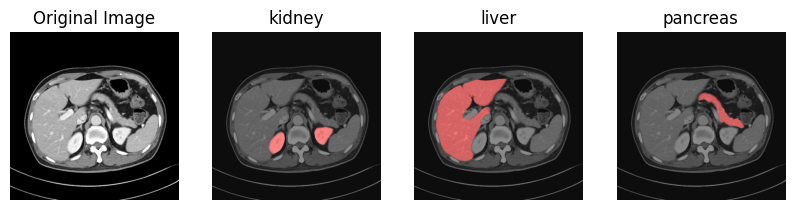

kidney P-value: 0.12360936483265111
liver P-value: 0.19248518235462578
pancreas P-value: 0.3463580214344786


In [85]:
image_path = 'examples/amos_0328.nii.gz'
text_prompt = ['kidney', 'liver', 'pancreas']
slide_idx = 68

image, pred_mask =  inference_nifti(image_path, text_prompt, is_CT=True, slice_idx=slide_idx, site='abdomen', rotate=1)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'CT-Abdomen', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')